In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2


import warnings
warnings.filterwarnings("ignore")

In [ ]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [ ]:
tr_df = train_df(r'C:\vit 7th semester\soft computing\dataset')

In [ ]:
tr_df

,Class Path,Class
0,C:\vit 7th semester\soft computing\dataset\ang...,anger
1,C:\vit 7th semester\soft computing\dataset\ang...,anger
2,C:\vit 7th semester\soft computing\dataset\ang...,anger
3,C:\vit 7th semester\soft computing\dataset\ang...,anger
4,C:\vit 7th semester\soft computing\dataset\ang...,anger
...,...,...
1189,C:\vit 7th semester\soft computing\dataset\sad...,sad
1190,C:\vit 7th semester\soft computing\dataset\sad...,sad
1191,C:\vit 7th semester\soft computing\dataset\sad...,sad
1192,C:\vit 7th semester\soft computing\dataset\sad...,sad


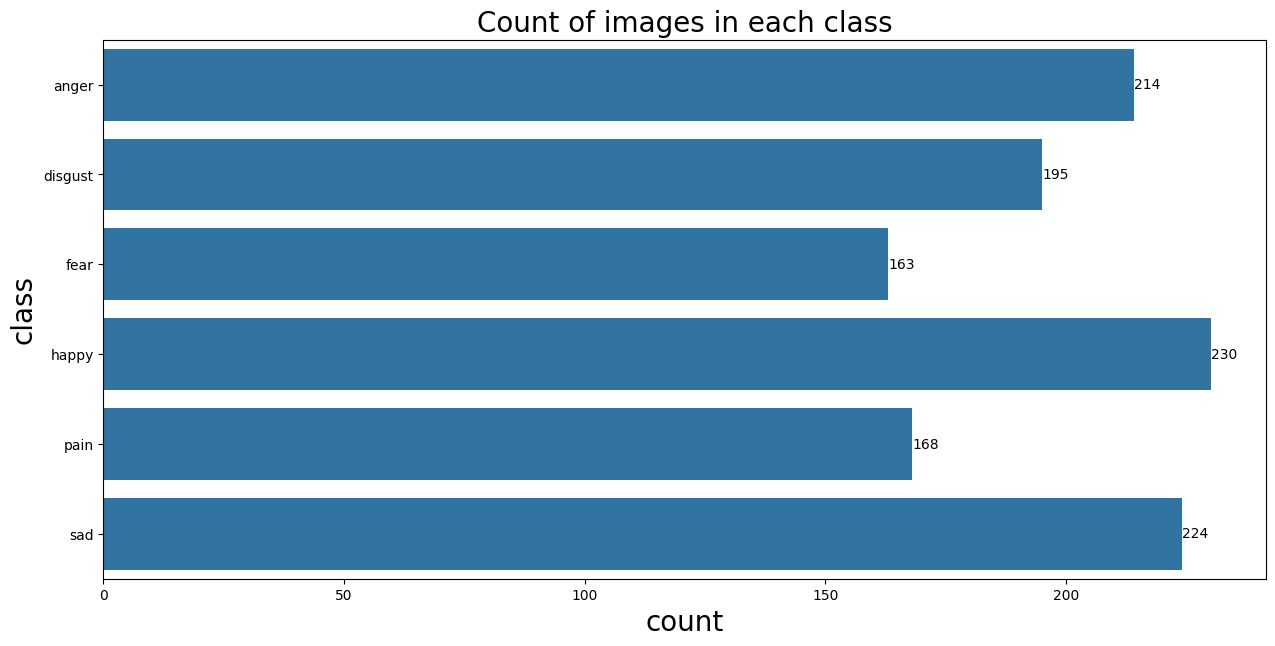

In [9]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('count',fontsize=20)
plt.ylabel('class',fontsize=20)
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [11]:
# 3. Split data into train, test and valid
tr_df, ts_df = train_test_split(tr_df,  train_size= 0.8, shuffle= True, random_state= 20)
valid_df, ts_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [13]:
ts_df

,Class Path,Class
920,C:\vit 7th semester\soft computing\dataset\pai...,pain
930,C:\vit 7th semester\soft computing\dataset\pai...,pain
1029,C:\vit 7th semester\soft computing\dataset\sad...,sad
1103,C:\vit 7th semester\soft computing\dataset\sad...,sad
175,C:\vit 7th semester\soft computing\dataset\ang...,anger
...,...,...
328,C:\vit 7th semester\soft computing\dataset\dis...,disgust
379,C:\vit 7th semester\soft computing\dataset\dis...,disgust
506,C:\vit 7th semester\soft computing\dataset\fea...,fear
1172,C:\vit 7th semester\soft computing\dataset\sad...,sad


In [15]:
# 4. Preprocessing
batch_size = 16
img_size = (224, 224)
img_shape = (224, 224, 3)

gen = ImageDataGenerator(rotation_range=30,
                         shear_range=.1,
                         zoom_range=.1,
                         horizontal_flip=True)

ts_gen = ImageDataGenerator()

tr_gen = gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                 y_col='Class', target_size=img_size,
                                 color_mode='rgb', shuffle=True,
                                 batch_size=batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class', target_size=img_size,
                                    color_mode='rgb', shuffle=True,
                                    batch_size=batch_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', target_size=img_size,
                                    color_mode='rgb', shuffle=False,
                                    batch_size=batch_size)

Found 915 validated image filenames belonging to 6 classes.
Found 115 validated image filenames belonging to 6 classes.
Found 116 validated image filenames belonging to 6 classes.


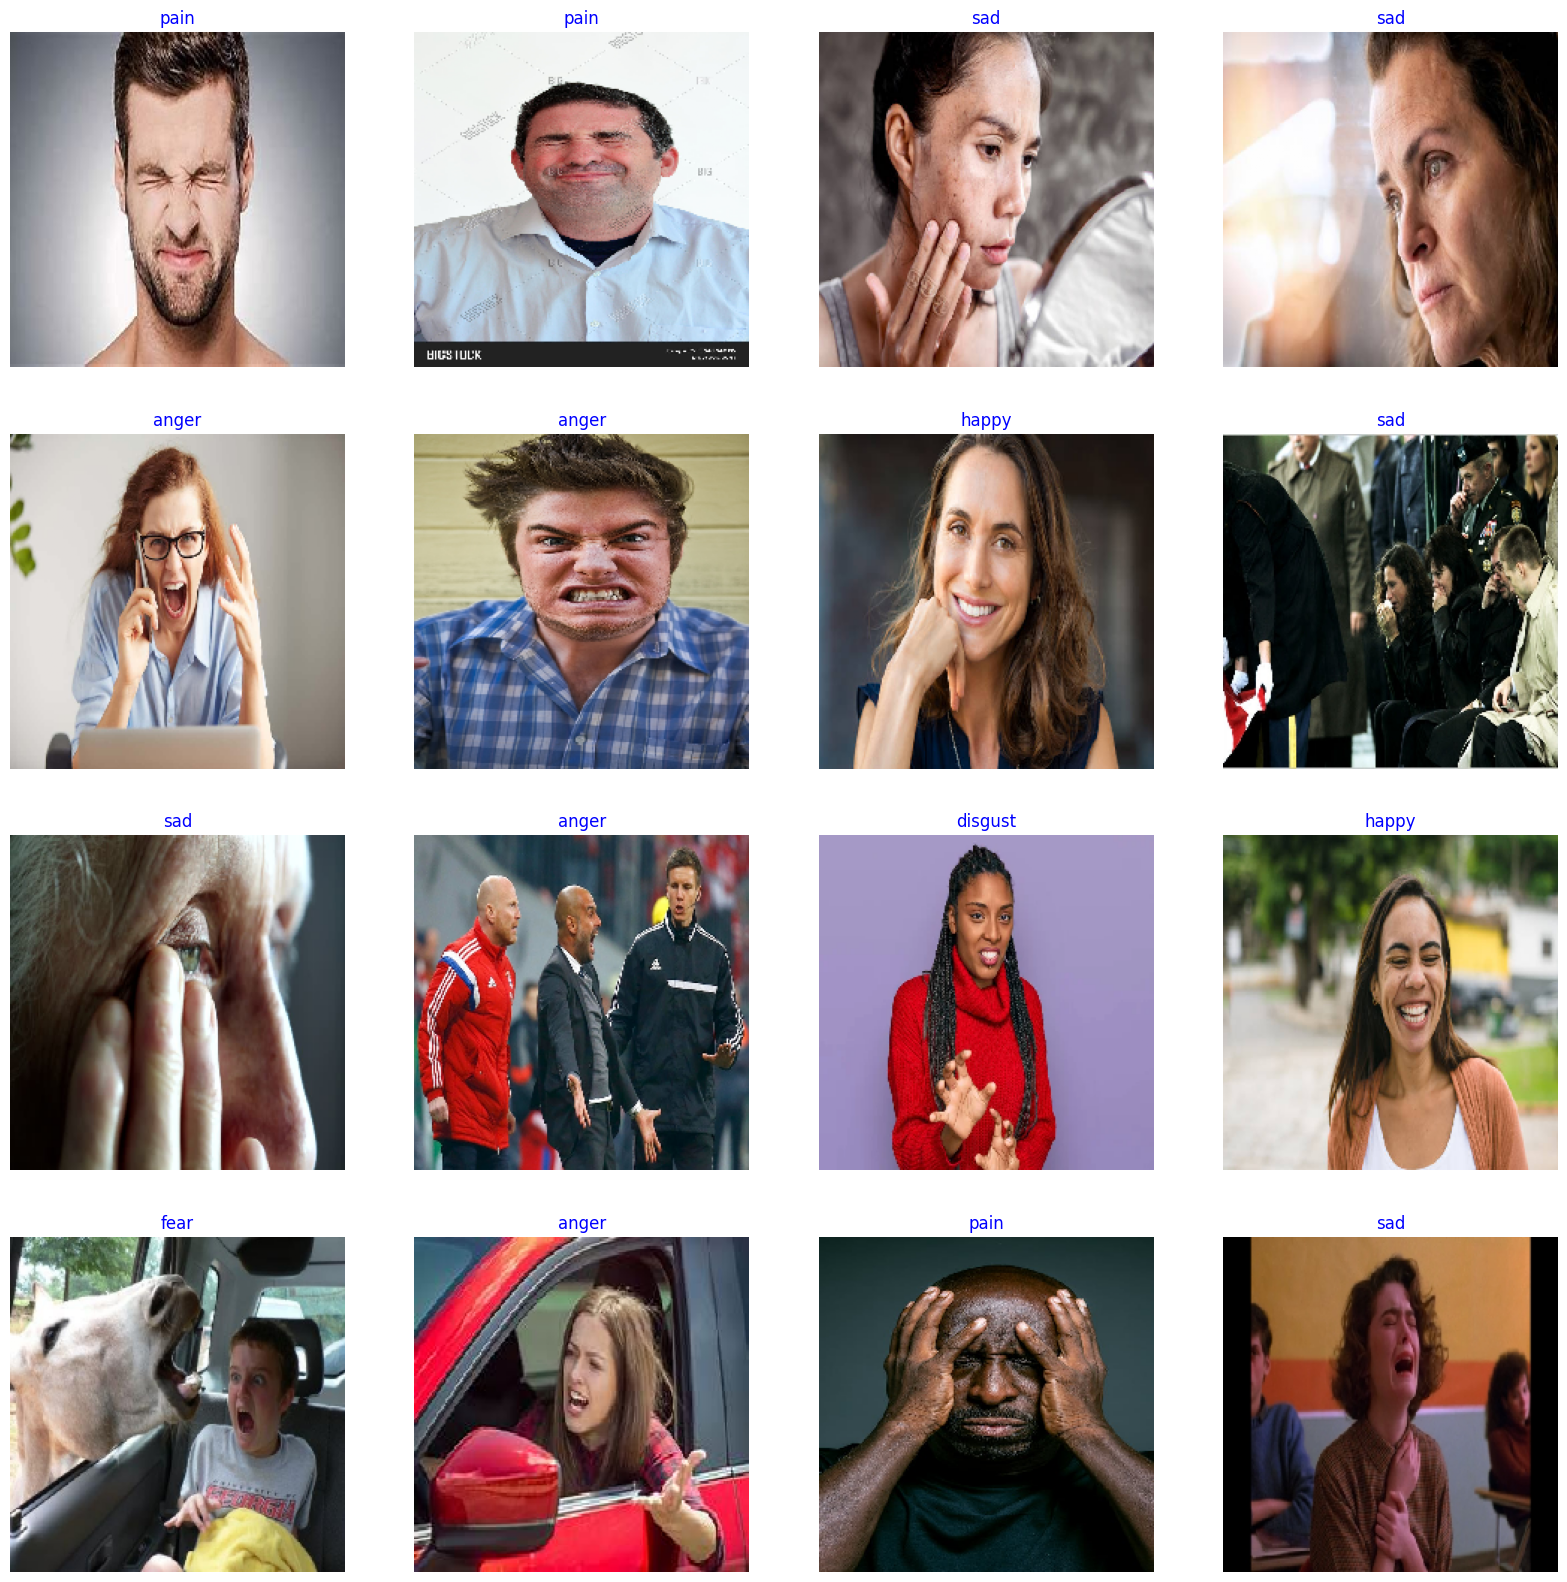

In [42]:
#4.1 Show samples from traning data
g_dict = tr_gen.class_indices      
g_dict = tr_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(ts_gen) 

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# 5. Build Deep Learning Model (MobileNetV2)


base_model = MobileNetV2(include_top=False, weights="imagenet",
                         input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dropout(rate=0.4, seed=20),
    Dense(6, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


In [19]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [23]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
# 6. Train the Model
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = model.fit(tr_gen, epochs=30,
                 validation_data=valid_gen,
                 callbacks=[tensorboard_callback])

Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 58s 829ms/step - accuracy: 0.1854 - loss: 6.6124 - precision: 0.1821 - recall: 0.1610 - val_accuracy: 0.2522 - val_loss: 1.9928 - val_precision: 0.2653 - val_recall: 0.1130
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - accuracy: 0.2440 - loss: 2.0207 - precision: 0.3042 - recall: 0.1175 - val_accuracy: 0.3478 - val_loss: 1.6136 - val_precision: 0.6667 - val_recall: 0.0174
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 651ms/step - accuracy: 0.2827 - loss: 1.6963 - precision: 0.4637 - recall: 0.0624 - val_accuracy: 0.3304 - val_loss: 1.5689 - val_precision: 1.0000 - val_recall: 0.0348
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 643ms/step - accuracy: 0.2542 - loss: 1.6898 - precision: 0.4621 - recall: 0.0366 - val_accuracy: 0.3478 - val_loss: 1.5826 - val_precision: 0.8000 - val_recall: 0.0348
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.3292 - loss: 1.6246 - precision: 0.5170 - recall: 0.0472 - val_accuracy: 0.3304 - val_los

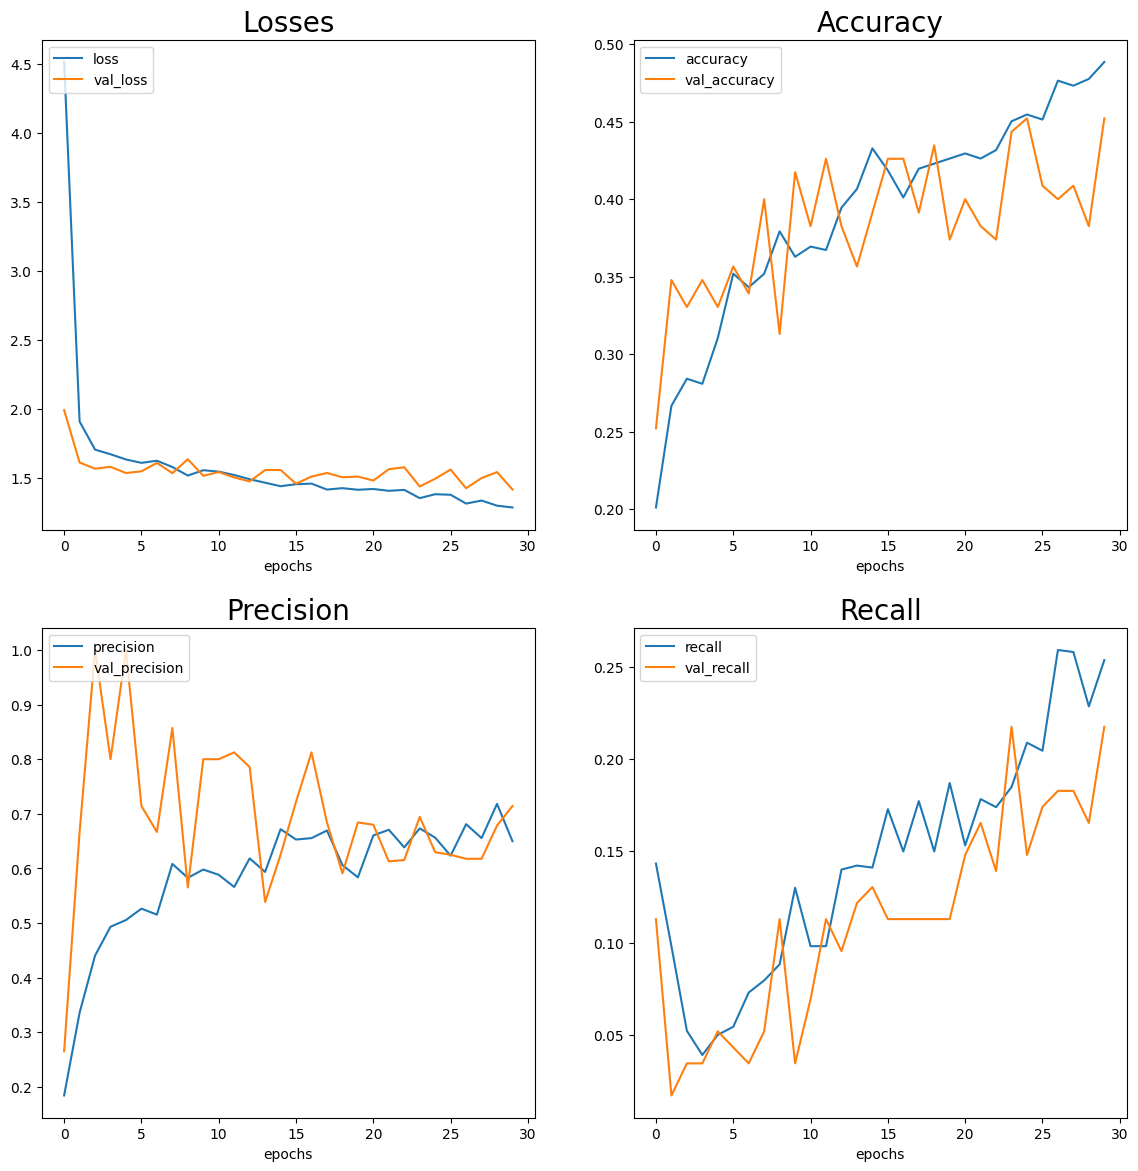

In [27]:
# 7. Plot Performance
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

In [29]:
# 8. Evaluate the Model
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - accuracy: 0.5466 - loss: 1.1926 - precision: 0.7732 - recall: 0.2970
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.4983 - loss: 1.4426 - precision: 0.6260 - recall: 0.1684
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - accuracy: 0.4866 - loss: 1.5107 - precision: 0.5463 - recall: 0.1774
Train Loss:  1.1918890476226807
Train Accuracy:  0.543169379234314
--------------------
Validation Loss:  1.4581459760665894
Validation Accuracy:  0.48695650696754456
--------------------
Test Loss:  1.5371750593185425
Test Accuracy:  0.4568965435028076


In [31]:
# Predict and Generate Classification Report
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 681ms/step


In [38]:
classes = list(tr_gen.class_indices.keys())  # Get class names from the training generator
from sklearn.metrics import classification_report
print(classification_report(ts_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

       anger       0.27      0.56      0.37        16
     disgust       0.38      0.47      0.42        17
        fear       0.54      0.65      0.59        20
       happy       0.57      0.21      0.31        19
        pain       0.50      0.29      0.36        14
         sad       0.65      0.50      0.57        30

    accuracy                           0.46       116
   macro avg       0.49      0.45      0.44       116
weighted avg       0.51      0.46      0.45       116



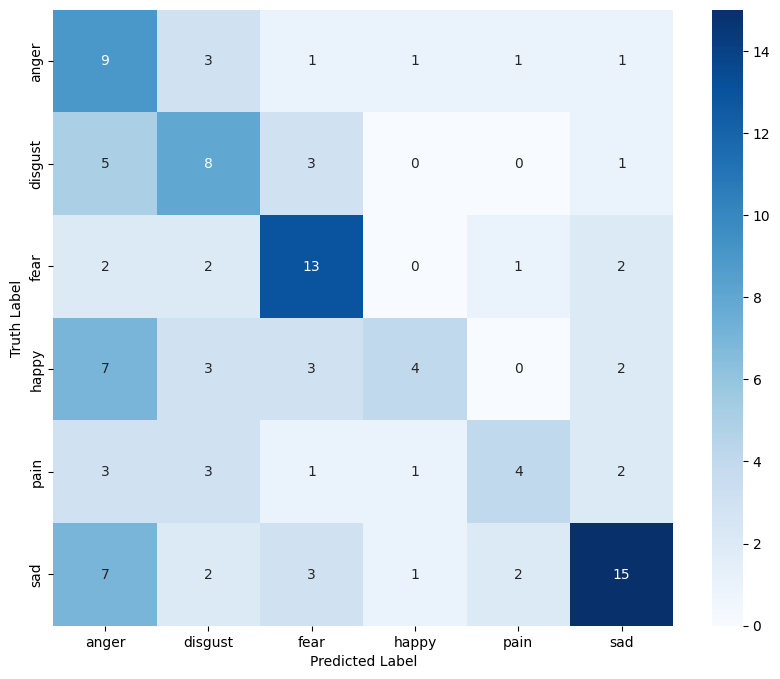

In [44]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(g_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()